In [1]:
from sklearn.utils import check_random_state
import numpy as np

In [2]:
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.spatial.distance import cdist

def euclidean_distances(X, Y=None, squared=False):
    """Compute pairwise distance between points in X and Y."""
    X2 = np.sum(X**2, axis=1, keepdims=True)
    if Y is None:
        Y = X
        Y2 = X2.T
    else:
        Y2 = np.sum(Y**2, axis=1, keepdims=True)
    dist = X2 + Y2 - 2*X@Y.T
    if squared:
        return dist
    else:
        return np.sqrt(dist)

def cdist(K, k, labels):
    """Calculate cluster distance."""
    
    idx = np.where(labels==k)[0]
    if idx.size == 0:
        return 0
    
    mu_k = np.sum([K[i,idx] for i in range(K.shape[0])], axis=0) / idx.size
    return np.diagonal(K).mean() - 2 * (K[:,idx] @ mu_k).mean()/idx.size + mu_k @ mu_k / idx.size**2


def rbf_kernel(X, gamma=1.0):
    """Calculate RBF kernel matrix."""
    pairwise_dists = euclidean_distances(X, squared=True)
    return np.exp(-gamma * pairwise_dists)

def _euclidean_distance(X, Y, squared=False):
    XX = np.dot(X,X.T).diagonal()[:, np.newaxis]
    YY = np.dot(Y,Y.T).diagonal()[np.newaxis, :]
    distances = (-2 * np.dot(X,Y.T)) + XX + YY
    np.maximum(distances, 0, out=distances)
    if X is Y:
        np.fill_diagonal(distances, 0)
    return distances if squared else np.sqrt(distances, out=distances)

def _pairwise_kernel(X, Y = None, kernel = 'rbf', d=1):
    if Y is None:
        Y = X
    
    if kernel == 'linear':
        return np.dot(X, Y.T)
    elif kernel == 'rbf':
        K = _euclidean_distance(X, Y, squared=True)
        K *= -d
        return np.exp(K, K)
    elif kernel.startswith('poly'):
        return (np.dot(X, Y.T)) ** d
    else:
        raise ValueError('Invalid kernel type.')

    
def cw_kmeans(X, n_clusters, max_iter=100, p=2.0, kernel='rbf'):
    """
    Implement CWK2M algorithm.
    
    Args:
        X (list): List of data matrices (views). Each view is a numpy array.
        n_clusters (int): Number of clusters.
        max_iter (int): Maximum number of iterations.
        p (float): Exponent for controlling cluster weight distribution.
        kernel (str): Kernel type ('linear' or 'rbf').
        
    Returns:
        labels (numpy array): Cluster labels. 
        cw (numpy array): Cluster weights.
    """
    
    # Get number of views
    v = len(X)
    
    # Get number of instances
    n = X[0].shape[0]
    
    # Initialize cluster labels randomly
    labels = np.random.randint(0, n_clusters, n)
    
    # Initialize cluster weights equally
    cw = np.full((v, n_clusters), 1/v) 
    
    # Calculate kernel matrix for each view
    # if kernel == 'linear':
    #     K = [np.dot(x, x.T) for x in X] 
    # elif kernel == 'rbf':
    #     K = [rbf_kernel(x, gamma=1/x.shape[1]) for x in X]
    K = np.array([_pairwise_kernel(x, d=0.01, kernel=kernel) for x in X])
        
    for i in range(max_iter):
        
        # Update cluster labels
        labels_prev = labels.copy()
        for j in range(n):
            dist = []
            for k in range(n_clusters):
                dist_k = 0
                for v in range(v):
                    dist_k += cw[v,k]**p * cdist(K[v][j], k, labels) 
                dist.append(dist_k)
            labels[j] = np.argmin(dist)
        
        # Update cluster weights
        if i > 0:
            for k in range(n_clusters):
                for v in range(v):
                    cw[v,k] = (cdist(K[v], k, labels) / 
                               sum([cdist(K[u], k, labels) for u in range(v)]))**(1/(p-1))
        
        # Normalize cluster weights
        for k in range(n_clusters):
            cw[:,k] = cw[:,k] / np.sum(cw[:,k]) 
        
        # Check convergence     
        if np.array_equal(labels, labels_prev):
            break
            
    return labels, cw

In [3]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate 2-view sample data
X1, y1 = make_blobs(n_samples=100, n_features=3, centers=3)
X2, y2 = make_blobs(n_samples=100, n_features=3, centers=3)

# Run CWK2M 
labels, cw = cw_kmeans([X1, X2], 3) 

# Plot results
f, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(X1[:,0], X1[:,1], c=labels, cmap='rainbow')
axes[0].set_title('View 1')
axes[1].scatter(X2[:,0], X2[:,1], c=labels, cmap='rainbow') 
axes[1].set_title('View 2');

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [13]:
import numpy as np

class CWKMeans:
    def __init__(self, X, n_clusters, gamma, max_iter=100, p=2):
        
        self.X = X
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.max_iter = max_iter
        self.p = p
        
    def fit(self):
        
        # Compute kernel matrices
        self.K = [rbf_kernel(x, x, self.gamma) for x in self.X]
        
        # Initialization
        n = self.K[0].shape[0]
        self.labels = np.random.randint(0, self.n_clusters, n)
        self.weights = np.full((len(self.X), self.n_clusters), 1 / len(self.X))
        
        for i in range(self.max_iter):
            
            # Kernel weighted distance
            def kWdist(v, j, k):
                idx = np.where(self.labels==k)[0]
                if len(idx) == 0: return 0
                mu_k = np.mean(self.K[v][idx]) 
                return self.K[v][j,j] - 2*np.mean(self.K[v][j,idx]) + mu_k
                
            # Update labels
            new_labels = []
            for j in range(n):
                dist = [0] * self.n_clusters
                for v in range(len(self.X)):
                    for k in range(self.n_clusters):
                        d = kWdist(v, j, k)**2
                        dist[k] += d * (self.weights[v][k]**self.p)
                new_labels.append(np.argmin(dist))
            self.labels = np.array(new_labels)

            # Update weights
            for k in range(self.n_clusters):
                kw_dist = []
                for v in range(len(self.X)):
                    d = kWdist(v, None, k) 
                    kw_dist.append(d**(-1/(self.p-1)))
                self.weights[:,k] = np.array(kw_dist) / np.sum(kw_dist)

        return self

In [14]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=200, n_features=15, centers=3)
X2, y2 = make_blobs(n_samples=200, n_features=15, centers=3)

ckm = CWKMeans([X1, X2], 3).fit()
labels = ckm.predict()



TypeError: __init__() missing 1 required positional argument: 'gamma'

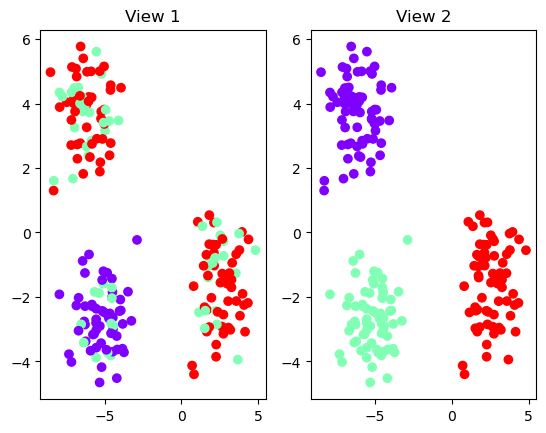

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X1[:,0], X1[:,1], c=labels, cmap='rainbow') 
ax2.scatter(X1[:,0], X1[:,1], c=y1, cmap='rainbow')
ax1.set_title('View 1')
ax2.set_title('View 2');

plt.show()

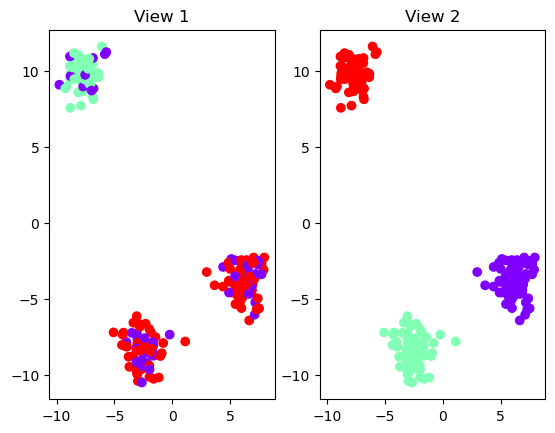

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X2[:,0], X2[:,1], c=labels, cmap='rainbow') 
ax2.scatter(X2[:,0], X2[:,1], c=y2, cmap='rainbow')
ax1.set_title('View 1')
ax2.set_title('View 2');

plt.show()

In [19]:
import numpy as np 
from sklearn.metrics.pairwise import rbf_kernel

class CWKernelKMeans:

    def __init__(self, X, n_clusters, gamma, max_iter=100, p=2):    
        self.X = X 
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.max_iter = max_iter
        self.p = p
        
    def fit(self):
        # Initialize
        n_samples = len(self.X[0]) 
        self.U = np.zeros((n_samples, self.n_clusters))
        self.K = [rbf_kernel(x, x, self.gamma) for x in self.X]
        self.weights = np.full((len(self.X), self.n_clusters), 1 / len(self.X))
        
        for i in range(self.max_iter):

            # Update cluster labels
            self.U *= 0
            for j in range(n_samples):
                dist = []
                for k in range(self.n_clusters):
                    for v in range(len(self.X)):  
                        dist.append(self.kernel_dist(k, j, v))
                # dist = [self.kernel_dist(k, j) for k in range(self.n_clusters)]
                self.U[j, np.argmin(dist)] = 1

            # Update cluster weights 
            for k in range(self.n_clusters):
                
                # Get points in cluster
                k_inds = np.where(self.U[:,k]==1)[0]
                
                # Compute kernel distance
                kw_dist = []
                for v in range(len(self.X)):
                    d = self.kernel_dist(k, k_inds, v)
                    kw_dist.append(d**(-1/(self.p-1)))
                
                # Update weights
                self.weights[:,k] = np.array(kw_dist) / np.sum(kw_dist)
                
        return self

    def kernel_dist(self, k, k_inds, v):
        
        # Mean of points in cluster k
        mu_k = np.mean(self.K[v][k_inds, k_inds])
        
        # Distance
        return np.diag(self.K[v]).mean() - 2 * np.mean(self.K[v][:,k_inds] @ mu_k) + mu_k**2
        
    def predict(self):
        return np.argmax(self.U, axis=1)

In [20]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

# Generate 2-view data
X1, y1 = make_blobs(n_samples=100, n_features=20, centers=3)
X2, y2 = make_blobs(n_samples=100, n_features=20, centers=3)

# Model
ckkm = CWKernelKMeans([X1, X2], 3, gamma=1)

# Fit 
ckkm.fit()

# Predict
y_pred = ckkm.predict()

# Accuracy
acc = accuracy_score(y1, y_pred)
print(f"Accuracy: {acc:.4f}")

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

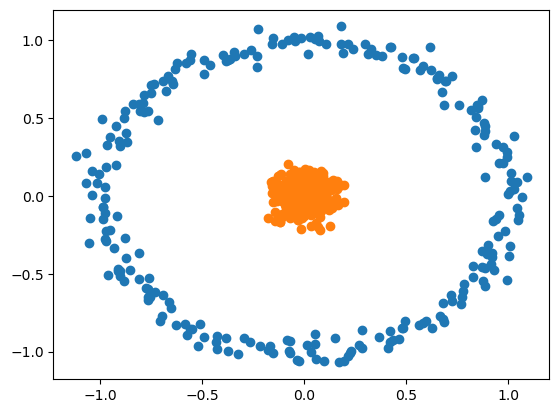

Converged at iteration 4


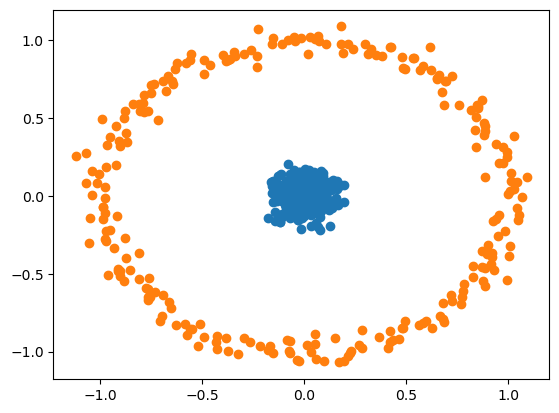

In [24]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.datasets import make_circles
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state


class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    (Weighted) Kernel K-means.
    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    A Unified View of Kernel K-means, Spectral Clustering and Graph Cuts.
    Inderjit S. Dhillon.
    Computer Science Department, University of Texas at Austin, 2004.
    Parameters
    ----------
    n_clusters : int, optional (default=3)
        Number of clusters.
    kernel : string {'linear', 'poly', 'rbf', 'sigmoid',
                     'cosine', 'precomputed'}, optional (default='rbf')
        Kernel used for PCA.
    gamma : {'scale', 'auto'} or float, default='scale'
        Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
        - if ``gamma='scale'`` (default) is passed then it uses
          1 / (n_features * X.var()) as value of gamma,
        - if 'auto', uses 1 / n_features
        - if float, must be non-negative
        - if None, set to 1 / n_features.    - if None
    degree : int, optional (default=3)
        Degree for poly kernels. Ignored by other kernels.
    coef0 : float, optional (default=1)
        Independent term in poly and sigmoid kernels.
        Ignored by other kernels.
    tol : float, optional (default=0)
        Convergence tolerance for arpack.
        If 0, optimal value will be chosen by arpack.
    max_iter : int, optional (default=None)
        Maximum number of iterations for arpack.
        If None, optimal value will be chosen by arpack.
    kernel_params : dict, optional (default=None)
        Parameters (keyword arguments) and
        values for kernel passed as callable object.
        Ignored by other kernels.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance
        used by np.random.
    """

    def __init__(
        self,
        n_clusters=3,
        kernel="rbf",
        gamma=None,
        degree=3,
        coef0=1,
        tol=1e-3,
        max_iter=50,
        kernel_params=None,
        random_state=None,
        verbose=0,
    ):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose

        if isinstance(self.gamma, str):  # "linear", "rbf", "poly"
            if self.gamma == "scale":
                X_var = X.var()
                self.gamma = 1.0 / (X.shape[1] * X_var) if X_var != 0 else 1.0
            elif self.gamma == "auto":
                self.gamma = 1.0 / X.shape[1]
            else:
                raise ValueError(
                    "When 'gamma' is a string, it should be either 'scale' or "
                    f"'auto'. Got '{self.gamma}' instead."
                )

    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma, "degree": self.degree, "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):

        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_, update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[np.ix_(mask, mask)]
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

        dist[:, :] += np.tile(np.expand_dims(np.diag(K), 1), (1, self.n_clusters))

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_, update_within=False)
        return dist.argmin(axis=1)


n_clusters = 2
n_samples = 500
max_iter = 100
random_state = 0

X, y = make_circles(
    n_samples=n_samples, factor=0.1, noise=0.05, random_state=random_state
)
for i in range(n_clusters):
    ind = y == i
    plt.scatter(X[ind, 0], X[ind, 1])
plt.show()

km = KernelKMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    gamma="scale",
    random_state=random_state,
    verbose=1,
)
pred = km.fit_predict(X)
for i in range(n_clusters):
    ind = pred == i
    plt.scatter(X[ind, 0], X[ind, 1])
plt.show()